<a href="https://colab.research.google.com/github/tijazz/Image_Processing/blob/main/Alzheimer_with_Scratch_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##########################################################################
# This project uses data from the following Kaggle dataset:
# https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images
#
# This code was originally run in Google Colab
# but should be able to be repurposed and run anywhere.
# Some packages such as google.colab.patches.cv2_imshow should be changed
# if run outside of a Google Colab environment.
##########################################################################

##########################################################################
# Importing Necessary Packages
##########################################################################

import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import RMSprop
from keras.preprocessing import image
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
get_ipython().run_line_magic('matplotlib', 'inline')
from skimage.io import imread
from sklearn.model_selection import train_test_split
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from google.colab.patches import cv2_imshow


In [ ]:
!unzip -uq "/content/Alzheimer_Dataset.zip" -d "/content/"

In [ ]:

##########################################################################
# First CNN
#
# This first model was built from scratch.
# The data was used based on how it was pre-split by Kaggle.
##########################################################################

# Read in the dataset

train_set = tf.keras.preprocessing.image_dataset_from_directory("/content/Alzheimer_Dataset/train",
                                                            validation_split = 0.2,
                                                            subset = 'training',
                                                            seed = 50,
                                                            image_size = (208, 176),
                                                            batch_size = 10)
validation_set = tf.keras.preprocessing.image_dataset_from_directory("/content/Alzheimer_Dataset/train",
                                                            validation_split = 0.2,
                                                            subset = 'validation',
                                                            seed = 50,
                                                            image_size = (208, 176),
                                                            batch_size = 10)
test_set = tf.keras.preprocessing.image_dataset_from_directory("/content/Alzheimer_Dataset/test",
                                                            seed = 50,
                                                            image_size = (208, 176),
                                                            batch_size = 10)


Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.
Found 1279 files belonging to 4 classes.


In [ ]:
# Set the class names

class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_set.class_names = class_names
test_set.class_names = class_names
validation_set.class_names = class_names


In [ ]:
# One-Hot encode the target (labels)

def one_hot_label(image, label):
    label = tf.one_hot(label, 4)
    return image, label
    
train_ds = train_set.map(one_hot_label)
validation_ds = validation_set.map(one_hot_label)
test_ds = test_set.map(one_hot_label)

In [ ]:
# Set up CNN Classifier using 'adam' optimizer,
# categorical cross entropy loss function, and AUC + accuracy as metrics
# with Early Stopping criteria

classifier= Sequential([Conv2D(16, kernel_size=3, padding='valid', activation='relu', input_shape=(208,176,3)),
                        MaxPool2D(pool_size = (2,2)),
                        Conv2D(32, kernel_size=3, padding='valid', activation='relu'),
                        MaxPool2D(pool_size = (2,2)),
                        Conv2D(64, kernel_size=3, padding='valid', activation='relu'),
                        MaxPool2D(pool_size = (2,2)),
                        Flatten(),
                        Dense(128, activation='relu'),
                        Dropout(.5),
                        Dense(64, activation='relu'),
                        Dropout(.5),
                        Dense(4, activation='softmax')])

classifier.compile(optimizer = 'adam', loss= 'categorical_crossentropy', metrics =['AUC', 'accuracy', 'CategoricalAccuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1)
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 206, 174, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 103, 87, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 101, 85, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 42, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 40, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 20, 64)       0

In [ ]:
# Fit CNN default (epochs = 60)

history = classifier.fit_generator(train_ds, epochs = 10, validation_data= validation_ds, callbacks=[es])

Epoch 1/10


<ipython-input-7-2d65fbe9e1f2>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = classifier.fit_generator(train_ds, epochs = 10, validation_data= validation_ds, callbacks=[es])


410/410 [==============================] - 162s 390ms/step - loss: 4.0063 - auc: 0.7396 - accuracy: 0.4515 - categorical_accuracy: 0.4515 - val_loss: 1.0157 - val_auc: 0.8148 - val_accuracy: 0.5176 - val_categorical_accuracy: 0.5176
Epoch 2/10
410/410 [==============================] - 154s 375ms/step - loss: 1.0627 - auc: 0.7812 - accuracy: 0.4818 - categorical_accuracy: 0.4818 - val_loss: 0.9820 - val_auc: 0.8170 - val_accuracy: 0.5186 - val_categorical_accuracy: 0.5186
Epoch 3/10
410/410 [==============================] - 161s 393ms/step - loss: 1.0360 - auc: 0.7897 - accuracy: 0.4865 - categorical_accuracy: 0.4865 - val_loss: 0.9756 - val_auc: 0.8198 - val_accuracy: 0.5186 - val_categorical_accuracy: 0.5186
Epoch 4/10
410/410 [==============================] - 159s 387ms/step - loss: 1.0169 - auc: 0.8003 - accuracy: 0.5001 - categorical_accuracy: 0.5001 - val_loss: 0.9647 - val_auc: 0.8285 - val_accuracy: 0.5342 - val_categorical_accuracy: 0.5342
Epoch 5/10
410/410 [===============

In [ ]:
# Evaluate the CNN on the test data

classifier.evaluate(test_ds)

128/128 [==============================] - 14s 105ms/step - loss: 0.9906 - auc: 0.8328 - accuracy: 0.5551 - categorical_accuracy: 0.5551


[0.9905753135681152,
 0.8328334093093872,
 0.5551211833953857,
 0.5551211833953857]

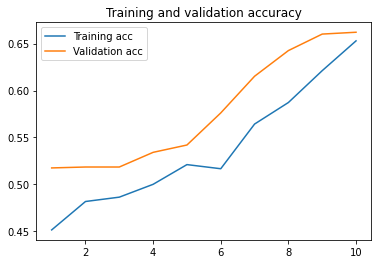

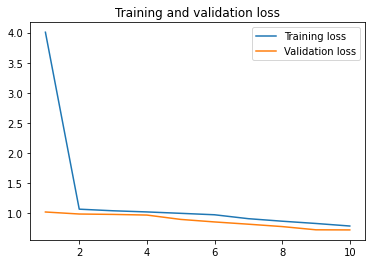

In [ ]:
# Plot the accuracy and the loss curves

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
##########################################################################
# Re-splitting the data
##########################################################################

# Read in all data again

train_nd_dir = '/content/Alzheimer_Dataset/train/NonDemented/'
train_vmild_dir = '/content/Alzheimer_Dataset/train/VeryMildDemented/'
train_mild_dir = '/content/Alzheimer_Dataset/train/MildDemented/'
train_mod_dir = '/content/Alzheimer_Dataset/train/ModerateDemented/'
test_nd_dir = '/content/Alzheimer_Dataset/test/NonDemented/'
test_vmild_dir = '/content/Alzheimer_Dataset/test/VeryMildDemented/'
test_mild_dir = '/content/Alzheimer_Dataset/test/MildDemented/'
test_mod_dir = '/content/Alzheimer_Dataset/test/ModerateDemented/'

train_x = []
train_y = []
test_x = []
test_y = []

#Changing the color of the image to gray

for image_path in os.listdir(train_nd_dir):
  img = imread(train_nd_dir + image_path, as_gray=True)
  img = img.astype('float32')
  img /= 255.0
  train_x.append(img)
  train_y.append('ND')
  
for image_path in os.listdir(train_vmild_dir):
  img = imread(train_vmild_dir+image_path, as_gray=True)
  img = img.astype('float32')
  img /= 255.0
  train_x.append(img)
  train_y.append('VMILD')

for image_path in os.listdir(train_mild_dir):
  img = imread(train_mild_dir+image_path, as_gray=True)
  img = img.astype('float32')
  img /= 255.0
  train_x.append(img)
  train_y.append('MILD')

for image_path in os.listdir(train_mod_dir):
  img = imread(train_mod_dir+image_path, as_gray=True)
  img = img.astype('float32')
  img /= 255.0
  train_x.append(img)
  train_y.append('MOD')

for image_path in os.listdir(test_nd_dir):
  img = imread(test_nd_dir+image_path, as_gray=True)
  img = img.astype('float32')
  img /= 255.0
  test_x.append(img)
  test_y.append('ND')
  
for image_path in os.listdir(test_vmild_dir):
  img = imread(test_vmild_dir+image_path, as_gray=True)
  img = img.astype('float32')
  img /= 255.0
  test_x.append(img)
  test_y.append('VMILD')

for image_path in os.listdir(test_mild_dir):
  img = imread(test_mild_dir+image_path, as_gray=True)
  img = img.astype('float32')
  img /= 255.0
  test_x.append(img)
  test_y.append('MILD')

for image_path in os.listdir(test_mod_dir):
  img = imread(test_mod_dir+image_path, as_gray=True)
  img = img.astype('float32')
  img /= 255.0
  test_x.append(img)
  test_y.append('MOD')


In [ ]:
# Combine all data into one large dataset and one-hot encode labels

train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

full_x = np.concatenate((train_x,test_x),axis=0)
full_y=np.concatenate((train_y,test_y),axis=0)
onehot = LabelBinarizer()
full_y = onehot.fit_transform(full_y)


In [ ]:
# Re-split training and testing data
# then split training into training and validation

train_x, test_x, train_y, test_y = train_test_split(full_x, full_y, test_size = 0.2, shuffle=True, random_state=33)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.2, shuffle=True, random_state=33)
train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape
train_x = np.array(train_x).reshape(4096,208,176,1)
val_x = np.array(val_x).reshape(1024,208,176,1)
test_x = np.array(test_x).reshape(1280,208,176,1)

In [ ]:
##########################################################################
# Transfer Learning
#
# We set up a transfer learning model using Resnet101
##########################################################################

# Prepare data for input into Resnet101

train_x_tmp = np.array(train_x).reshape(4096,208,176)
val_x_tmp = np.array(val_x).reshape(1024,208,176)
test_x_tmp = np.array(test_x).reshape(1280,208,176)

print(train_x_tmp.shape)
train_x_3c = np.repeat(train_x_tmp[..., np.newaxis], 3, -1)
print(train_x_3c.shape) 
print(val_x_tmp.shape)
val_x_3c = np.repeat(val_x_tmp[..., np.newaxis], 3, -1)
print(val_x_3c.shape)  
print(test_x_tmp.shape)
test_x_3c = np.repeat(test_x_tmp[..., np.newaxis], 3, -1)
print(test_x_3c.shape) 


(4096, 208, 176)
(4096, 208, 176, 3)
(1024, 208, 176)
(1024, 208, 176, 3)
(1280, 208, 176)
(1280, 208, 176, 3)


In [ ]:
# Bring in Resnet101 and make it untrainable
# Add more trainable layers

pretrained_model = keras.applications.ResNet101(include_top=False, input_shape=(208,176,3))
pretrained_model.trainable = False

model_tl = keras.Sequential([
    pretrained_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(4, activation='softmax')
])


171446536/171446536 [==============================] - 7s 0us/step


In [ ]:
# Compiling and fitting transfer learning model default (epochs = 50)

model_tl.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(),metrics=['AUC','accuracy','categorical_accuracy'])
checkpoint_tl = ModelCheckpoint("checkpoint_model_tl_res.h5", save_best_only=True)
es_tl = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1)

history_tl = model_tl.fit(train_x_3c, train_y, validation_data=(val_x_3c, val_y), batch_size=10, epochs = 10, callbacks=[es_tl, checkpoint_tl])


Epoch 1/10
410/410 [==============================] - 1179s 3s/step - loss: 2.2620 - auc: 0.7354 - accuracy: 0.4858 - categorical_accuracy: 0.4858 - val_loss: 1.2238 - val_auc: 0.7777 - val_accuracy: 0.4854 - val_categorical_accuracy: 0.4854
Epoch 2/10
271/410 [==================>...........] - ETA: 5:18 - loss: 1.1924 - auc: 0.7756 - accuracy: 0.4993 - categorical_accuracy: 0.4993

In [ ]:
# Plot accuracy and loss curves

plt.plot(history_tl.history['categorical_accuracy'], label="Training Accuracy")
plt.plot(history_tl.history['val_categorical_accuracy'], label="Validation Accuracy")
plt.legend(loc="best")
plt.show()
plt.plot(history_tl.history['loss'], label="Training Loss")
plt.plot(history_tl.history['val_loss'], label="Validation Loss")
plt.legend(loc="best")
plt.show()


In [ ]:
# Evaluate model and build confusion matrix

test_results_tl = model_tl.evaluate(x=test_x_3c, y=test_y)

pred_test_tl = model_tl.predict(test_x_3c, verbose = 1)
pred_test_tl = onehot.inverse_transform(pred_test_tl)

real_val = onehot.inverse_transform(test_y)
cm_tl = confusion_matrix(real_val, pred_test_tl, labels=['ND', 'VMILD', 'MILD', 'MOD'])
cm_tl_df = pd.DataFrame(cm_tl, columns=['ND', 'VMILD', 'MILD', 'MOD'], index=['ND', 'VMILD', 'MILD', 'MOD'])
cm_tl_df.columns.name = 'Predicted'
cm_tl_df.index.name = 'Actual'
sns.heatmap(cm_tl_df, annot=True, fmt='g', cmap='Greens')

In [ ]:
##########################################################################
# Final CNN
#
# This model was built from scratch.
# The dataset used was after the re-split.
##########################################################################

# Create CNN

classifier = Sequential()
classifier.add(Conv2D(64, (5,5), strides=(2,2), padding='valid', activation='relu', input_shape=(208,176,1)))
classifier.add(MaxPooling2D(2))
classifier.add(Conv2D(128, (5,5), strides=(2,2), padding='valid', activation='relu'))
classifier.add(Conv2D(256, (5,5), strides=(2,2), padding='valid', activation='relu'))
classifier.add(MaxPooling2D(2))
classifier.add(Flatten())
classifier.add(Dense(64, activation='relu'))
classifier.add(Dropout(0.4))
classifier.add(Dense(32, activation='relu'))
classifier.add(Dropout(0.4))
classifier.add(Dense(4, activation='softmax'))
classifier.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(),metrics=['AUC','accuracy','categorical_accuracy'])
checkpoint_cb = ModelCheckpoint("checkpoint_model.h5", save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1)
classifier.summary()

In [ ]:
# Fit CNN  default(epochs = 50)

history = classifier.fit(train_x, train_y, validation_data=(val_x, val_y), batch_size=10, epochs = 10, callbacks=[es, checkpoint_cb])


In [ ]:
# Plot accuracy and loss curves

plt.plot(history.history['categorical_accuracy'], label="Training Accuracy")
plt.plot(history.history['val_categorical_accuracy'], label="Validation Accuracy")
plt.legend(loc="best")
plt.show()
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend(loc="best")
plt.show()


In [ ]:
# Evaluate on test set and create confusion matrix

test_results = classifier.evaluate(x=test_x, y=test_y)

pred_test = classifier.predict(test_x, verbose = 1)
pred_test = onehot.inverse_transform(pred_test)
real_val = onehot.inverse_transform(test_y)

cm = confusion_matrix(real_val, pred_test, labels=['ND', 'VMILD', 'MILD', 'MOD'])
cm_df = pd.DataFrame(cm, columns=['ND', 'VMILD', 'MILD', 'MOD'], index=['ND', 'VMILD', 'MILD', 'MOD'])
cm_df.columns.name = 'Predicted'
cm_df.index.name = 'Actual'
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Greens')

In [ ]:
##########################################################################
# Experimenting with Different Prediction Thresholds
#
# Here we attempt to modify the thresholds in order to
# avoid costly misclassifications.
##########################################################################

# load in the model checkpoint from the final CNN model

model = keras.models.load_model('checkpoint_model.h5')
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics =['AUC','acc'])


In [ ]:
# Recreate confusion matrix with standard classification rules
# i.e. predict class with highest probability

pred_test = model.predict(x=test_x)
pred_test = model.predict(test_x, verbose = 1)
pred_test = onehot.inverse_transform(pred_test)
real_val = onehot.inverse_transform(test_y)
real_val = onehot.inverse_transform(test_y)
cm_tl = confusion_matrix(real_val, pred_test, labels=['ND', 'VMILD', 'MILD', 'MOD'])
cm_tl_df = pd.DataFrame(cm_tl, columns=['ND', 'VMILD', 'MILD', 'MOD'], index=['ND', 'VMILD', 'MILD', 'MOD'])
cm_tl_df.columns.name = 'Predicted'
cm_tl_df.index.name = 'Actual'
sns.heatmap(cm_tl_df, annot=True, fmt='g', cmap='Greens')

In [ ]:
# Calculate individual prediction probabilities
# This time only predict ND (non-demented) if its probability
# is a certain threshold higher than the next highest probability.
# In the code below, this threshold is set at 0.9

pred_prob = model.predict(test_x)
predictions=[]
classes=['MILD','MOD','ND','VMILD']
for probs in pred_prob:
  inds = np.argsort(probs)
  if inds[len(inds)-1] != 2:
    predictions.append(classes[inds[len(inds)-1]])
  else:
    index_top = inds[len(inds)-1]
    index_second = inds[len(inds)-2]
    if probs[index_top] - probs[index_second] < 0.9:
      predictions.append(classes[inds[len(inds)-2]])
    else:
      predictions.append(classes[inds[len(inds)-1]])

In [ ]:
# show new confusion matrix

real_val = onehot.inverse_transform(test_y)
cm_tl = confusion_matrix(real_val, predictions, labels=['ND', 'VMILD', 'MILD', 'MOD'])
cm_tl_df = pd.DataFrame(cm_tl, columns=['ND', 'VMILD', 'MILD', 'MOD'], index=['ND', 'VMILD', 'MILD', 'MOD'])
cm_tl_df.columns.name = 'Predicted'
cm_tl_df.index.name = 'Actual'
sns.heatmap(cm_tl_df, annot=True, fmt='g', cmap='Greens')


In [ ]:
##########################################################################
# Visualizing the CNN
#
# In this section, we try to visualize different stages of the CNN
# as well as find the most important sections of the images
##########################################################################

# Prepare data for visualizing activation

train_x_tmp = np.array(train_x).reshape(4096,208,176)
val_x_tmp = np.array(val_x).reshape(1024,208,176)
test_x_tmp = np.array(test_x).reshape(1280,208,176)

layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(train_x_tmp[0].reshape(1,208,176,1))

In [ ]:
# Define function to display activation layer

def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

# Visualize randomly selected image

plt.imshow(train_x[0][:,:,0], cmap='gray')

In [ ]:
# Display activations for each of the three convolutional layers
# Will display in 8x8 grid but this can be changed

display_activation(activations, 8, 8, 1)
display_activation(activations, 8, 8, 2)
display_activation(activations, 8, 8, 3)

In [ ]:
# Define function to show heatmap of image.
# Sections of the image that are more important will be shown with a red overlay
# on top of the actual image

def show_heatmap(file_path):
  img = imread(file_path, as_gray=True)
  cv2_imshow(cv2.imread(file_path)) # Visualize image
  img = img.astype('float32')
  img /= 255
  x = image.img_to_array(img)
  x=np.reshape(x, (1, 208, 176, 1))
  preds = model.predict(x)
  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('conv2d_2')
    iterate = Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = keras.backend.mean(grads, axis=(0, 1, 2))
  
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape((10, 8))
  plt.matshow(heatmap)
  plt.show()

  img = cv2.imread(file_path)
  INTENSITY = 0.5
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
  img = heatmap * INTENSITY + img

  cv2_imshow(img)

In [ ]:
# Show heatmap for image
# show_heatmap takes a file path as a parameter

show_heatmap('/content/Alzheimer_Dataset/train/ModerateDemented/moderateDem1.jpg')